In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [2]:
# Step 2: Load the dataset
bank_data = pd.read_csv('bank-full.csv', sep=';')

# Step 3: Select the required columns
columns_needed = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day',
    'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'
]
bank_data = bank_data[columns_needed]

# Step 4: Split the dataset into train, validation, and test sets
train_data, temp_data = train_test_split(bank_data, test_size=0.4, random_state=1)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1)

# Step 5: Calculate AUC for numerical variables
numerical_columns = ['balance', 'day', 'duration', 'previous']
y_train = train_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

for col in numerical_columns:
    auc = roc_auc_score(y_train, train_data[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -train_data[col])
    print(f"AUC for {col}: {auc}")

AUC for balance: 0.5916931412945473
AUC for day: 0.5291275984648961
AUC for duration: 0.8128648066681694
AUC for previous: 0.5986704105715122


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [3]:
# Step 6: Prepare the data for training
train_dict = train_data.drop(columns='y').to_dict(orient='records')
validation_dict = validation_data.drop(columns='y').to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_validation = dv.transform(validation_dict)
y_train = train_data['y'].apply(lambda x: 1 if x == 'yes' else 0)
y_validation = validation_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Step 7: Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_validation)[:, 1]
auc = roc_auc_score(y_validation, y_pred)
print(f"AUC on validation set: {auc:.3f}")

AUC on validation set: 0.900


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865


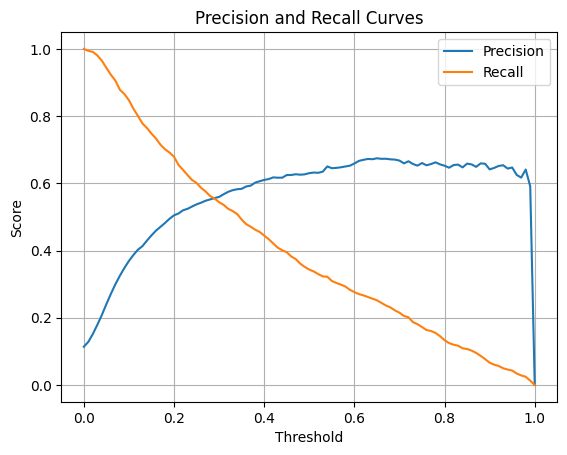

Threshold where precision and recall curves intersect: 0.29


In [4]:
# Step 8: Calculate precision, recall, and F1 score for thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred >= threshold).astype(int)
    precision = precision_score(y_validation, y_pred_threshold, zero_division=0)
    recall = recall_score(y_validation, y_pred_threshold)
    precisions.append(precision)
    recalls.append(recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1)

# Plot precision and recall curves
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.grid()
plt.show()

# Find the threshold where precision and recall intersect
intersection_threshold = None
for i in range(len(thresholds)):
    if np.isclose(precisions[i], recalls[i], atol=0.01):
        intersection_threshold = thresholds[i]
        break

print(f"Threshold where precision and recall curves intersect: {intersection_threshold}")


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62



In [5]:
# Find the threshold where F1 score is maximal
max_f1_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold where F1 score is maximal: {max_f1_threshold}")

Threshold where F1 score is maximal: 0.2


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26



In [6]:
# Step 9: 5-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)

    # Predict and calculate AUC
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc)

# Calculate standard deviation of AUC scores
std_auc = np.std(auc_scores)
print(f"Standard deviation of AUC scores across folds: {std_auc:.4f}")


Standard deviation of AUC scores across folds: 0.0041


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [7]:
# Step 10: Hyperparameter tuning using 5-Fold cross-validation
C_values = [0.000001, 0.001, 1]

best_mean_score = -1
best_C = None
best_std = None

for C in C_values:
    auc_scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train logistic regression model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        # Predict and calculate AUC
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        auc_scores.append(auc)

    mean_auc = round(np.mean(auc_scores), 3)
    std_auc = round(np.std(auc_scores), 3)
    print(f"C={C}: mean AUC={mean_auc}, std AUC={std_auc}")

    # Determine the best C based on mean AUC and std
    if mean_auc > best_mean_score or (mean_auc == best_mean_score and (best_std is None or std_auc < best_std)):
        best_mean_score = mean_auc
        best_C = C
        best_std = std_auc

print(f"Best C: {best_C} with mean AUC: {best_mean_score} and std: {best_std}")


C=1e-06: mean AUC=0.696, std AUC=0.008
C=0.001: mean AUC=0.854, std AUC=0.006
C=1: mean AUC=0.908, std AUC=0.004
Best C: 1 with mean AUC: 0.908 and std: 0.004
